# *1.DATA COLLECTION*


In [3]:
# ============== LOAD DATASET DAN IMPORT
import pandas as pd
import numpy as np
from collections import Counter
import tkinter as tk
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv("Datasset LKS AI Kabupaten Malang 2025.csv")

X = df.drop("target", axis=1)
y = df["target"].values

# *2.DATA CLEANING*

In [4]:
# Cek nilai yang hilang
print("Nilai yang hilang tiap kolom:")
df.isnull().sum()

Nilai yang hilang tiap kolom:


age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

In [5]:
# Hapus duplikasi
df.drop_duplicates()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3,0
299,45,1,3,110,264,0,1,132,0,1.2,1,0,3,0
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3,0
301,57,1,0,130,131,0,1,115,1,1.2,1,1,3,0


In [6]:
# Cek tipe data
print("\nInfo dataset setelah cleaning:")
df.info()


Info dataset setelah cleaning:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


# *3.EDA*


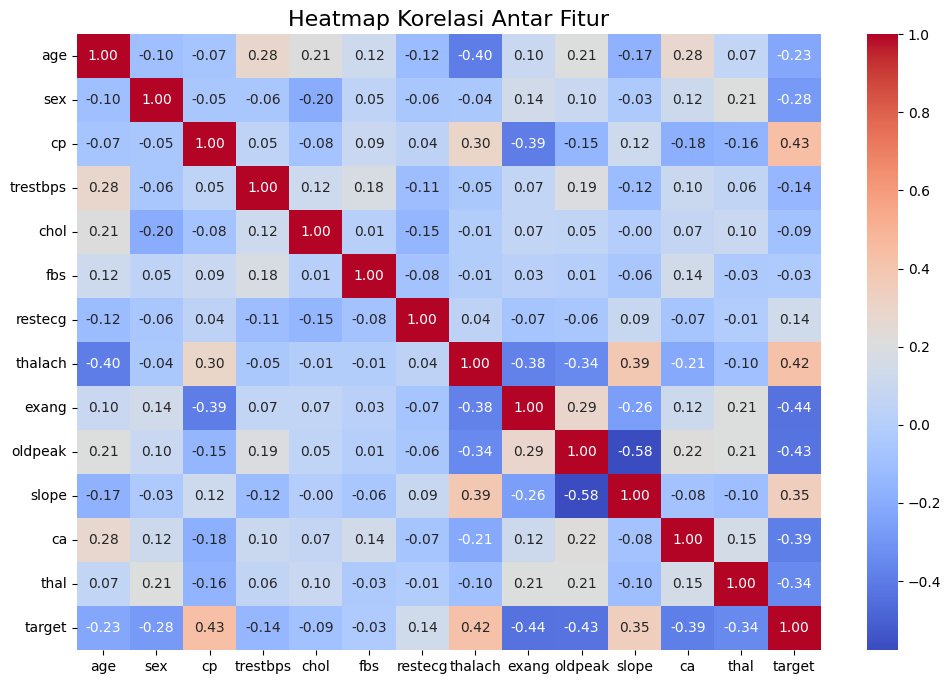

In [7]:
# Hitung korelasi
corr = df.corr()

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Heatmap Korelasi Antar Fitur", fontsize=16)
plt.show()


# *5.MODELLING*

In [8]:
# ============== FUNGSI UNTUK MEMISAHKAN DATA TRAIN DAN TEST
def train_test_split_manual(X, y, test_size=0.2, random_state=None):
    if random_state is not None:
        np.random.seed(random_state)
    n = len(X)
    idx = np.arange(n)
    np.random.shuffle(idx)
    test_count = int(n * test_size)
    test_idx = idx[:test_count]
    train_idx = idx[test_count:]
    return X.iloc[train_idx], X.iloc[test_idx], y[train_idx], y[test_idx]

In [9]:
# ============== SPLIT / MEMBAGI DATASET
X_train, X_test, y_train, y_test = train_test_split_manual(X, y, test_size=0.2, random_state=42)

In [10]:
# ============== IMPLEMENTASI DECISION TREE
class DecisionTree:
    def __init__(self, max_depth: int = 5):
        self.max_depth = max_depth
        self.tree = None

    def gini(self, y):
        m = len(y)
        if m == 0:
            return 0
        counts = Counter(y)
        return 1 - sum((count/m)**2 for count in counts.values())

    def best_split(self, X, y):
        best_gini = 1.0
        best_idx, best_val = None, None
        m, n = X.shape

        for idx in range(n):
            values = X[:, idx]
            for val in np.unique(values):
                left_mask = values <= val
                right_mask = ~left_mask
                if sum(left_mask) == 0 or sum(right_mask) == 0:
                    continue

                gini_left = self.gini(y[left_mask])
                gini_right = self.gini(y[right_mask])
                gini_split = (sum(left_mask)/m) * gini_left + (sum(right_mask)/m) * gini_right

                if gini_split < best_gini:
                    best_gini = gini_split
                    best_idx = idx
                    best_val = val
        return best_idx, best_val

    def build_tree(self, X, y, depth=0):
        if depth >= self.max_depth or len(set(y)) == 1:
            return Counter(y).most_common(1)[0][0]

        idx, val = self.best_split(X, y)
        if idx is None:
            return Counter(y).most_common(1)[0][0]

        left_mask = X[:, idx] <= val
        right_mask = ~left_mask

        return {
            "feature": idx,
            "value": val,
            "left": self.build_tree(X[left_mask], y[left_mask], depth+1),
            "right": self.build_tree(X[right_mask], y[right_mask], depth+1)
        }

    def fit(self, X, y):
        self.tree = self.build_tree(np.array(X), np.array(y))

    def predict_one(self, row, node):
        if not isinstance(node, dict):
            return node
        if row[node["feature"]] <= node["value"]:
            return self.predict_one(row, node["left"])
        else:
            return self.predict_one(row, node["right"])

    def predict(self, X):
        return [self.predict_one(row, self.tree) for row in np.array(X)]


# *6.EVALUATION*

In [11]:
# ============== TRAINING DAN PREDIKSI
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

clf = DecisionTree(max_depth=3)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# --- hitung akurasi manual ---
correct = sum(y_pred[i] == y_test[i] for i in range(len(y_test)))
accuracy = correct / len(y_test)
print(f"Akurasi: {accuracy:.2f}")

# --- confusion matrix manual ---
TP = sum((y_pred[i] == 1) and (y_test[i] == 1) for i in range(len(y_test)))
TN = sum((y_pred[i] == 0) and (y_test[i] == 0) for i in range(len(y_test)))
FP = sum((y_pred[i] == 1) and (y_test[i] == 0) for i in range(len(y_test)))
FN = sum((y_pred[i] == 0) and (y_test[i] == 1) for i in range(len(y_test)))

print("Confusion Matrix:")
print(f"TP: {TP}, FP: {FP}")
print(f"FN: {FN}, TN: {TN}")

print("Prediksi:", y_pred)
print("Target Asli:", y_test.tolist())

Akurasi: 0.88
Confusion Matrix:
TP: 29, FP: 4
FN: 3, TN: 24
Prediksi: [np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0)]
Target Asli: [0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

# *7.REPORTING/PRESENTASION*

In [12]:
def predict_input():
    # Ambil input semua kolom
    row_data = {}
    for col in X.columns:
        val = entries[col].get()
        try:
            row_data[col] = float(val)
        except ValueError:
            row_data[col] = 0.0

    df_input = pd.DataFrame([row_data])

    # Prediksi
    pred = clf.predict(df_input)[0]
    hasil_var.set(f"Prediksi target: {pred} (1=positif penyakit jantung, 0=negatif)")


root = tk.Tk()
root.title("Prediksi Penyakit Jantung (Decision Tree)")

entries = {}
for i, col in enumerate(X.columns):
    tk.Label(root, text=col).grid(row=i, column=0, sticky="w")
    e = tk.Entry(root)
    e.grid(row=i, column=1)
    entries[col] = e

hasil_var = tk.StringVar()
tk.Label(root, textvariable=hasil_var, fg="blue").grid(row=len(X.columns), columnspan=2)

tk.Button(root, text="Prediksi", command=predict_input).grid(row=len(X.columns)+1, columnspan=2)

root.mainloop()